In [ ]:
!pip install -q lightgbm joblib scikit-learn pandas matplotlib seaborn --quiet
print('Install complete')


Install complete


In [ ]:
import os, joblib, math, warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
warnings.filterwarnings('ignore')
print('Imports ready')


Imports ready


In [ ]:
possible_paths = [
    '/content/drive/MyDrive/Colab Notebooks/SEMS/ESK17311.csv',
    '/content/ESK17311.csv',
    '/mnt/data/ESK17311.csv'
]

file_path = None
for p in possible_paths:
    if os.path.exists(p):
        file_path = p
        break

if file_path is None:
    from google.colab import files
    print('Please upload the Eskom CSV (ESK17311.csv) when prompted.')
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

print('Loading file:', file_path)
df = pd.read_csv(file_path)
print('Raw shape:', df.shape)
df.head()


Please upload the Eskom CSV (ESK17311.csv) when prompted.


Saving ESK17311.csv to ESK17311.csv
Loading file: ESK17311.csv
Raw shape: (43824, 5)


,Date Time Hour Beginning,Residual Forecast,RSA Contracted Forecast,Residual Demand,ILS Usage
0,2021-04-01 12:00:00 AM,21076.232,21833.271,21177.801,0.0
1,2021-04-01 01:00:00 AM,20803.317,21453.623,20886.668,0.0
2,2021-04-01 02:00:00 AM,20752.810,21284.327,20822.775,0.0
3,2021-04-01 03:00:00 AM,20871.016,21396.662,21068.201,0.0
4,2021-04-01 04:00:00 AM,22089.175,22639.893,22216.935,0.0


In [ ]:
df.columns = [c.strip() for c in df.columns]
print('Columns:', df.columns.tolist())

expected_ts = 'Date Time Hour Beginning'
expected_target = 'Residual Demand'

if expected_ts not in df.columns:
    print('WARNING: expected timestamp column', expected_ts, 'not found. Available columns:')
    print(df.columns.tolist())

if expected_target not in df.columns:
    raise SystemExit(f"Expected '{expected_target}' column not found — edit the notebook to use the correct column name.")

df['timestamp'] = pd.to_datetime(df[expected_ts], errors='coerce')
df['residual_demand'] = pd.to_numeric(df[expected_target], errors='coerce')

df = df.dropna(subset=['timestamp']).reset_index(drop=True)
print('After parse shape:', df.shape)
print(df[['timestamp','residual_demand']].head())


Columns: ['Date Time Hour Beginning', 'Residual Forecast', 'RSA Contracted Forecast', 'Residual Demand', 'ILS Usage']
After parse shape: (43824, 7)
            timestamp  residual_demand
0 2021-04-01 00:00:00        21177.801
1 2021-04-01 01:00:00        20886.668
2 2021-04-01 02:00:00        20822.775
3 2021-04-01 03:00:00        21068.201
4 2021-04-01 04:00:00        22216.935


Timestamp range: 2021-04-01 00:00:00 -> 2026-03-31 23:00:00
count    39912.000000
mean     23469.175532
std       2808.827838
min      15634.673000
25%      21252.791750
50%      23378.881000
75%      25438.495500
max      34029.030000
Name: residual_demand, dtype: float64


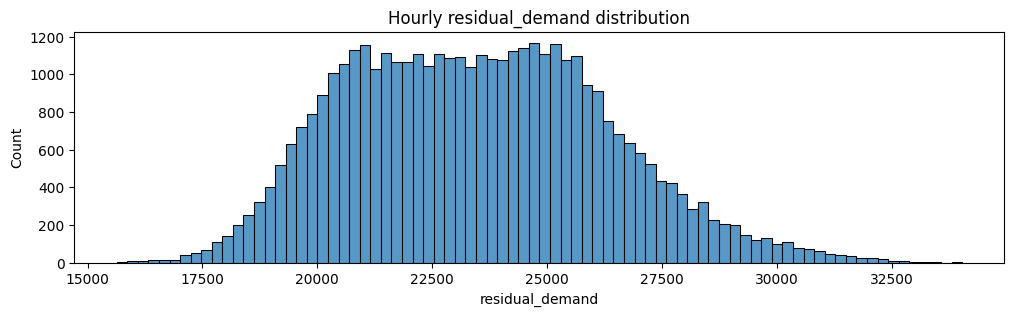

In [ ]:
print('Timestamp range:', df['timestamp'].min(), '->', df['timestamp'].max())
print(df['residual_demand'].describe())

plt.figure(figsize=(12,3))
sns.histplot(df['residual_demand'], bins=80, kde=False)
plt.title('Hourly residual_demand distribution')
plt.show()


In [ ]:
df = df.sort_values('timestamp').reset_index(drop=True)

df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

lags = [1, 24, 168]
for lag in lags:
    df[f'lag_{lag}'] = df['residual_demand'].shift(lag)

roll_windows = [3, 24, 168]
for w in roll_windows:
    df[f'roll_mean_{w}'] = df['residual_demand'].shift(1).rolling(window=w, min_periods=1).mean()

df_model = df.dropna(subset=['lag_1']).reset_index(drop=True)
print('df_model shape (after lags):', df_model.shape)
df_model.head()


df_model shape (after lags): (39912, 17)


,Date Time Hour Beginning,Residual Forecast,RSA Contracted Forecast,Residual Demand,ILS Usage,timestamp,residual_demand,hour,weekday,month,is_weekend,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24,roll_mean_168
0,2021-04-01 01:00:00 AM,20803.317,21453.623,20886.668,0.0,2021-04-01 01:00:00,20886.668,1,3,4,0,21177.801,NaN,NaN,21177.801000,21177.801000,21177.801000
1,2021-04-01 02:00:00 AM,20752.810,21284.327,20822.775,0.0,2021-04-01 02:00:00,20822.775,2,3,4,0,20886.668,NaN,NaN,21032.234500,21032.234500,21032.234500
2,2021-04-01 03:00:00 AM,20871.016,21396.662,21068.201,0.0,2021-04-01 03:00:00,21068.201,3,3,4,0,20822.775,NaN,NaN,20962.414667,20962.414667,20962.414667
3,2021-04-01 04:00:00 AM,22089.175,22639.893,22216.935,0.0,2021-04-01 04:00:00,22216.935,4,3,4,0,21068.201,NaN,NaN,20925.881333,20988.861250,20988.861250
4,2021-04-01 05:00:00 AM,24476.193,25048.864,24275.534,0.0,2021-04-01 05:00:00,24275.534,5,3,4,0,22216.935,NaN,NaN,21369.303667,21234.476000,21234.476000


In [ ]:
TARGET = 'residual_demand'
features = [c for c in df_model.columns if c not in ['timestamp','residual_demand','Date Time Hour Beginning','Residual Demand','date']]
features = [f.replace(' ', '_') for f in features]
df_model = df_model.rename(columns={c: c.replace(' ', '_') for c in df_model.columns})

X = df_model[features]
y = df_model[TARGET]

split_idx = int(len(df_model) * 0.8)
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

print('Features used:', features)
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape)


Features used: ['Residual_Forecast', 'RSA_Contracted_Forecast', 'ILS_Usage', 'hour', 'weekday', 'month', 'is_weekend', 'lag_1', 'lag_24', 'lag_168', 'roll_mean_3', 'roll_mean_24', 'roll_mean_168']
Train shape: (31929, 13) Val shape: (7983, 13)


In [ ]:
params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'num_leaves': 20,
    'max_depth': 8,
    'min_data_in_leaf': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'random_state': 42
}

model = lgb.LGBMRegressor(**params)
print('Fitting LightGBM (this may take a few minutes)...')

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='mae',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=50)]
)

Fitting LightGBM (this may take a few minutes)...
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 31929, number of used features: 13
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Start training from score 23768.080915
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.02, max_depth=8,
              min_data_in_leaf=100, n_estimators=2000, num_leaves=20,
              random_state=42, reg_alpha=0.5, reg_lambda=2.0, subsample=0.8)

### Model Evaluation

In [ ]:
y_pred = model.predict(X_val.iloc[:-1])

mae = mean_absolute_error(y_val.iloc[:-1], y_pred)
rmse = np.sqrt(mean_squared_error(y_val.iloc[:-1], y_pred))
r2 = r2_score(y_val.iloc[:-1], y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Mean Absolute Error (MAE): 270.43
Root Mean Squared Error (RMSE): 360.27
R-squared (R2): 0.98


### Visualize Predictions

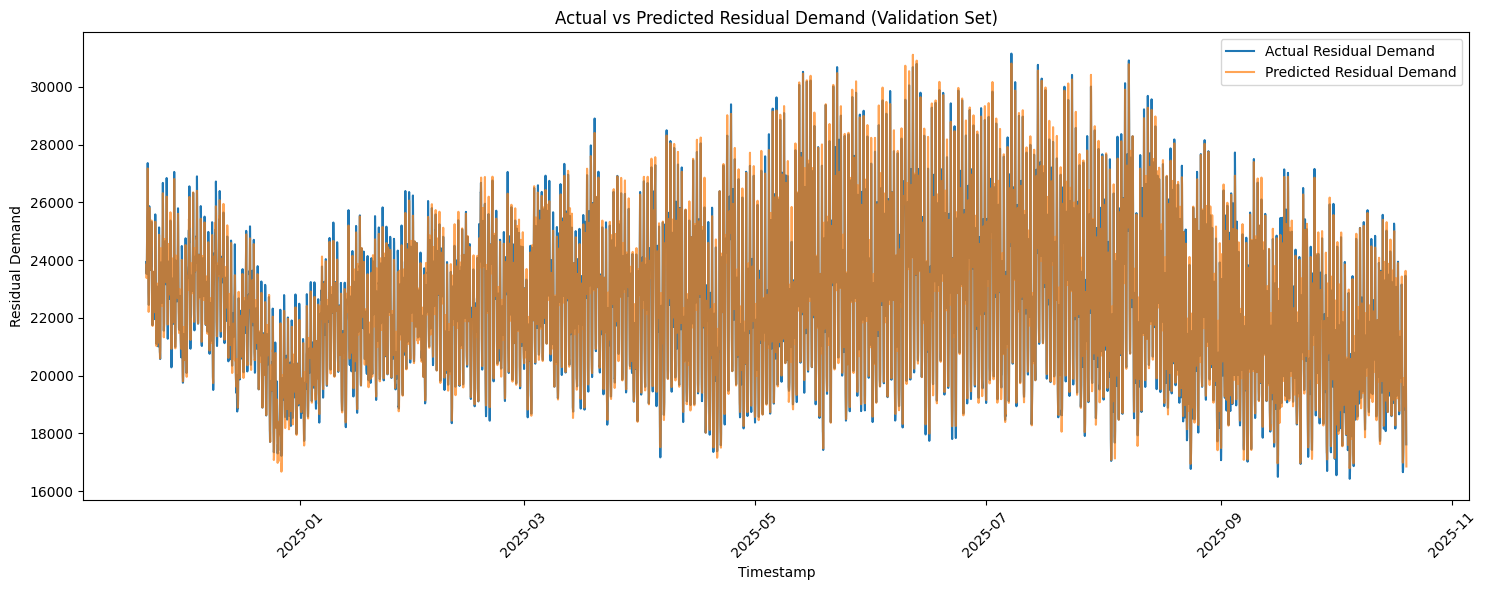

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_model['timestamp'].iloc[split_idx:], y_val, label='Actual Residual Demand')
plt.plot(df_model['timestamp'].iloc[split_idx:], y_pred, label='Predicted Residual Demand', alpha=0.7)
plt.title('Actual vs Predicted Residual Demand (Validation Set)')
plt.xlabel('Timestamp')
plt.ylabel('Residual Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Val MAE: 270.4290 | RMSE: 360.2735 | R2: 0.979341
Actual range: 16423.854 -> 31153.245
Pred range:   16672.44536229269 -> 31112.520308947136


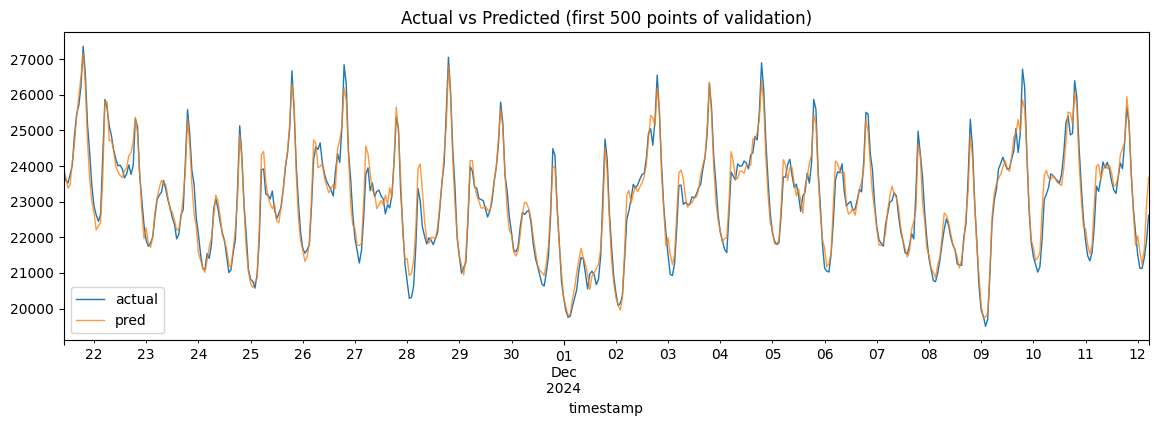

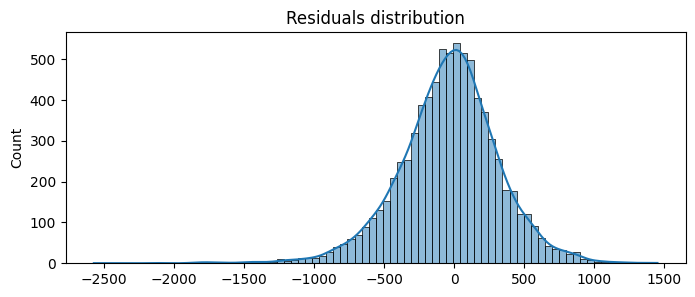

<Figure size 800x600 with 0 Axes>

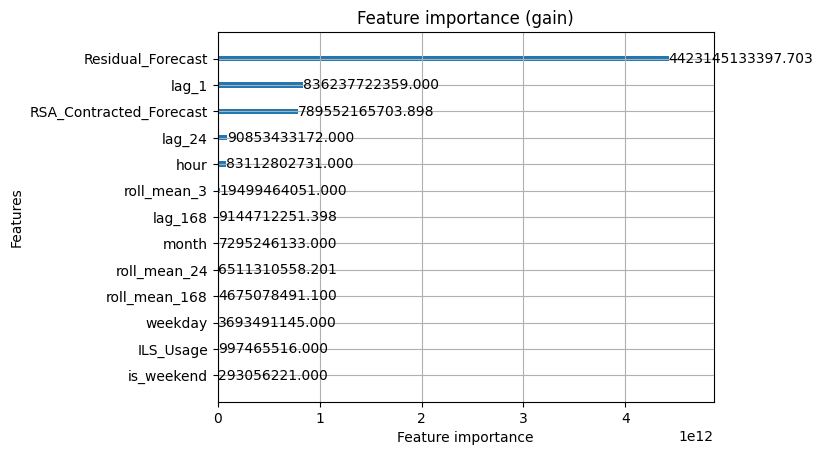

In [ ]:
X_val_cleaned = X_val.iloc[:-1]
y_val_cleaned = y_val.iloc[:-1]

y_pred = model.predict(X_val_cleaned)
mae = mean_absolute_error(y_val_cleaned, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_cleaned, y_pred))
r2 = r2_score(y_val_cleaned, y_pred)

print(f'Val MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.6f}')
print('Actual range:', y_val_cleaned.min(), '->', y_val_cleaned.max())
print('Pred range:  ', y_pred.min(), '->', y_pred.max())

comp = pd.DataFrame({'timestamp': df_model['timestamp'].iloc[split_idx:].values[:-1], 'actual': y_val_cleaned.values, 'pred': y_pred})
comp = comp.set_index('timestamp')
plt.figure(figsize=(14,4))
comp['actual'].iloc[:500].plot(label='actual', linewidth=1)
comp['pred'].iloc[:500].plot(label='pred', linewidth=1, alpha=0.8)
plt.legend(); plt.title('Actual vs Predicted (first 500 points of validation)')
plt.show()

res = comp['actual'] - comp['pred']
plt.figure(figsize=(8,3))
sns.histplot(res, bins=80, kde=True)
plt.title('Residuals distribution')
plt.show()

plt.figure(figsize=(8,6))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Feature importance (gain)')
plt.show()

In [ ]:
joblib.dump(model, 'energy_model_eskom_regularized.joblib')
print('Saved model: energy_model_eskom_regularized.joblib')

Saved model: energy_model_eskom_regularized.joblib


In [ ]:
print('Model file:', os.path.abspath('energy_model_eskom_regularized.joblib'))
try:
    from google.colab import files
    files.download('energy_model_eskom_regularized.joblib')
except Exception as e:
    print('If not in Colab, find the file in the current working directory.')


Model file: /content/energy_model_eskom_regularized.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(model, 'energy_model_5features.joblib')
print("Saved energy_model_5features.joblib")